### Moive Recommendation

In this notebook, I use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/).

An introduction about this small dataset can be seen from this [link](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html).

The whole project with the visualization can be seen from this [link](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/8554488083666860/3313189036436457/6195906399611815/latest.html).

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [0]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

# Part1: Data ETL and Data Exploration

In [0]:
movies_df = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links_df = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags_df = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [0]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [0]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [0]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [0]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [0]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


## Spark SQL and Online analytical processing (OLAP)

In [0]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/databricks/spark/python/pyspark/sql/dataframe.py:331: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


### Q1: The number of Users

In [0]:
#ratings_df.select("movieId").distinct().count()
# Method - 1
q1_result=spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
q1_result.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



### Q2: The number of Movies

In [0]:
q2_result=spark.sql("Select Count(movieId) as Number_of_Moives from movies")
q2_result.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



### Q3:  How many movies are rated by users? List movies not rated before

In [0]:
ratings_df.select("movieId").distinct().count()

Out[10]: 9724

That is we have 9742 movies in total and 9724 of them have been rated by users.

Therefore, we have 18 movies never be rated before. Let's see the genres and title of these 18 movies.

In [0]:
# movies that have not been rated before
unrated_movies = spark.sql("""
  SELECT title,genres FROM Movies 
    WHERE movieId NOT IN 
    (SELECT DISTINCT movieId FROM ratings)
""")
unrated_movies.show()

+--------------------+--------------------+
|               title|              genres|
+--------------------+--------------------+
|Innocents, The (1...|Drama|Horror|Thri...|
|      Niagara (1953)|      Drama|Thriller|
|For All Mankind (...|         Documentary|
|Color of Paradise...|               Drama|
|I Know Where I'm ...|   Drama|Romance|War|
|  Chosen, The (1981)|               Drama|
|Road Home, The (W...|       Drama|Romance|
|      Scrooge (1970)|Drama|Fantasy|Mus...|
|        Proof (1991)|Comedy|Drama|Romance|
|Parallax View, Th...|            Thriller|
|This Gun for Hire...|Crime|Film-Noir|T...|
|Roaring Twenties,...|Crime|Drama|Thriller|
|Mutiny on the Bou...|Adventure|Drama|R...|
|In the Realms of ...|Animation|Documen...|
|Twentieth Century...|              Comedy|
|Call Northside 77...|Crime|Drama|Film-...|
|Browning Version,...|               Drama|
|  Chalet Girl (2011)|      Comedy|Romance|
+--------------------+--------------------+



create a table that is downloadable

In [0]:
%sql
SELECT DISTINCT title, genres FROM movies WHERE movieId NOT IN (SELECT DISTINCT movieId FROM ratings)

title genres This Gun for Hire (1942) Crime|Film-Noir|Thriller Chosen, The (1981) Drama Innocents, The (1961) Drama|Horror|Thriller Niagara (1953) Drama|Thriller Scrooge (1970) Drama|Fantasy|Musical Browning Version, The (1951) Drama I Know Where I'm Going! (1945) Drama|Romance|War For All Mankind (1989) Documentary Twentieth Century (1934) Comedy Call Northside 777 (1948) Crime|Drama|Film-Noir Chalet Girl (2011) Comedy|Romance Color of Paradise, The (Rang-e khoda) (1999) Drama Mutiny on the Bounty (1962) Adventure|Drama|Romance Proof (1991) Comedy|Drama|Romance In the Realms of the Unreal (2004) Animation|Documentary Road Home, The (Wo de fu qin mu qin) (1999) Drama|Romance Roaring Twenties, The (1939) Crime|Drama|Thriller Parallax View, The (1974) Thriller

### Q4: List Movie Genres

In [0]:
%sql
SELECT DISTINCT title, genres From movies

title genres Color of Night (1994) Drama|Thriller Surviving the Game (1994) Action|Adventure|Thriller Little Big League (1994) Comedy|Drama Whatever (1998) Drama Ronin (1998) Action|Crime|Thriller Pink Flamingos (1972) Comedy Austin Powers: The Spy Who Shagged Me (1999) Action|Adventure|Comedy Erin Brockovich (2000) Drama Porky's Revenge (1985) Comedy Angel Heart (1987) Film-Noir|Horror|Mystery|Thriller D.O.A. (1988) Film-Noir|Mystery|Thriller Extreme Days (2001) Action|Adventure|Comedy|Drama MacArthur (1977) Drama Madame Bovary (1991) Drama Body of Evidence (1993) Drama|Thriller War and Peace (1956) Drama|Romance|War Flight of the Phoenix, The (1965) Action|Adventure|Drama My Boss's Daughter (2003) Comedy|Romance Wonderland (2003) Crime|Drama|Mystery|Thriller Intolerance: Love's Struggle Throughout the Ages (1916) Drama Virgin Spring, The (Jungfrukällan) (1960) Crime|Drama Shaun of the Dead (2004) Comedy|Horror Primer (2004) Drama|Sci-Fi Snow Walker, The (2003) Adventure|Drama Short Film About Love, A (Krótki film o milosci) (1988) Drama|Romance Matador, The (2005) Comedy|Drama|Thriller District 13 (Banlieue 13) (2004) Action|Crime|Sci-Fi Let's Go to Prison (2006) Comedy Lucky You (2007) Comedy|Drama Awake (2007) Drama|Thriller Legionnaire (1998) Action|Adventure|Drama|War Up in the Air (2009) Drama|Romance Date Night (2010) Action|Comedy|Romance Iron Man 2 (2010) Action|Adventure|Sci-Fi|Thriller|IMAX Winter's Bone (2010) Drama|Thriller Knight and Day (2010) Action|Comedy|Romance Last Exorcism, The (2010) Horror|Thriller Going the Distance (2010) Comedy|Romance What's Your Number? (2011) Comedy|Romance Safe Haven (2013) Drama|Mystery|Romance Epic (2013) Adventure|Animation|Fantasy Justice League: Crisis on Two Earths (2010) Action|Animation|Sci-Fi Black Sea (2015) Adventure|Mystery|Thriller Terminator Genisys (2015) Action|Adventure|Sci-Fi|Thriller The Duke of Burgundy (2014) Drama Rock the Kasbah (2015) Comedy Winter in Prostokvashino (1984) Animation Young Poisoner's Handbook, The (1995) Crime|Drama Awfully Big Adventure, An (1995) Drama Blink (1994) Thriller Coneheads (1993) Comedy|Sci-Fi So I Married an Axe Murderer (1993) Comedy|Romance|Thriller Hype! (1996) Documentary Head Above Water (1996) Comedy|Thriller Sliding Doors (1998) Drama|Romance Madeline (1998) Children|Comedy Dark Crystal, The (1982) Adventure|Fantasy Beetlejuice (1988) Comedy|Fantasy Peeping Tom (1960) Drama|Horror|Thriller Christine (1983) Horror Airport '77 (1977) Drama Killer's Kiss (1955) Crime|Film-Noir Angela's Ashes (1999) Drama Gold Rush, The (1925) Adventure|Comedy|Romance For the Boys (1991) Comedy|Drama|Musical Baby Boy (2001) Crime|Drama Let It Ride (1989) Comedy Polyester (1981) Comedy Chasing Papi (a.k.a. Papi Chulo) (2003) Comedy Once Bitten (1985) Comedy|Horror Beethoven's 2nd (1993) Children|Comedy Undercurrent (1946) Film-Noir|Thriller Sniper (1993) Action|Drama Man Who Came to Dinner, The (1942) Comedy Baadasssss! (How to Get the Man's Foot Outta Your Ass) (2003) Drama Twilight Samurai, The (Tasogare Seibei) (2002) Drama|Romance Dr. Giggles (1992) Comedy|Horror C.R.A.Z.Y. (2005) Drama Stardust (2007) Adventure|Comedy|Fantasy|Romance 30 Days of Night (2007) Horror|Thriller Before the Devil Knows You're Dead (2007) Crime|Drama|Thriller Like Stars on Earth (Taare Zameen Par) (2007) Drama Forgetting Sarah Marshall (2008) Comedy|Romance Winnie the Pooh and Tigger Too (1974) Animation|Children Trance (2013) Crime|Thriller Scouts Guide to the Zombie Apocalypse (2015) Action|Comedy|Horror Self-criticism of a Bourgeois Dog (2017) Comedy What's Eating Gilbert Grape (1993) Drama Barbarella (1968) Adventure|Comedy|Sci-Fi Fled (1996) Action|Adventure It's a Wonderful Life (1946) Children|Drama|Fantasy|Romance Old Man and the Sea, The (1958) Adventure|Drama Apocalypse Now (1979) Action|Drama|War High Noon (1952) Drama|Western Red Corner (1997) Crime|Thriller Twilight (1998) Crime|Drama|Thriller Nightmare on Elm Street 3: Dream Warriors, A (1987) Hor

Noticed that the genres are seperated by "|". Therefore, one possible way to deal with this situation is to use dataframe to split the data.

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit
#make use of udf to connect lambda and dataframe interaction
extract_genres = udf(lambda x: x.split("|"), ArrayType(StringType()))
movies_df_clean = movies_df.select("movieId", "title", extract_genres("genres").alias("genres"))
display(movies_df_clean)

movieId title genres 1 Toy Story (1995) List(Adventure, Animation, Children, Comedy, Fantasy) 2 Jumanji (1995) List(Adventure, Children, Fantasy) 3 Grumpier Old Men (1995) List(Comedy, Romance) 4 Waiting to Exhale (1995) List(Comedy, Drama, Romance) 5 Father of the Bride Part II (1995) List(Comedy) 6 Heat (1995) List(Action, Crime, Thriller) 7 Sabrina (1995) List(Comedy, Romance) 8 Tom and Huck (1995) List(Adventure, Children) 9 Sudden Death (1995) List(Action) 10 GoldenEye (1995) List(Action, Adventure, Thriller) 11 American President, The (1995) List(Comedy, Drama, Romance) 12 Dracula: Dead and Loving It (1995) List(Comedy, Horror) 13 Balto (1995) List(Adventure, Animation, Children) 14 Nixon (1995) List(Drama) 15 Cutthroat Island (1995) List(Action, Adventure, Romance) 16 Casino (1995) List(Crime, Drama) 17 Sense and Sensibility (1995) List(Drama, Romance) 18 Four Rooms (1995) List(Comedy) 19 Ace Ventura: When Nature Calls (1995) List(Comedy) 20 Money Train (1995) List(Action, Comedy, Crime, Drama, Thriller) 21 Get Shorty (1995) List(Comedy, Crime, Thriller) 22 Copycat (1995) List(Crime, Drama, Horror, Mystery, Thriller) 23 Assassins (1995) List(Action, Crime, Thriller) 24 Powder (1995) List(Drama, Sci-Fi) 25 Leaving Las Vegas (1995) List(Drama, Romance) 26 Othello (1995) List(Drama) 27 Now and Then (1995) List(Children, Drama) 28 Persuasion (1995) List(Drama, Romance) 29 City of Lost Children, The (Cité des enfants perdus, La) (1995) List(Adventure, Drama, Fantasy, Mystery, Sci-Fi) 30 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) List(Crime, Drama) 31 Dangerous Minds (1995) List(Drama) 32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) List(Mystery, Sci-Fi, Thriller) 34 Babe (1995) List(Children, Drama) 36 Dead Man Walking (1995) List(Crime, Drama) 38 It Takes Two (1995) List(Children, Comedy) 39 Clueless (1995) List(Comedy, Romance) 40 Cry, the Beloved Country (1995) List(Drama) 41 Richard III (1995) List(Drama, War) 42 Dead Presidents (1995) List(Action, Crime, Drama) 43 Restoration (1995) List(Drama) 44 Mortal Kombat (1995) List(Action, Adventure, Fantasy) 45 To Die For (1995) List(Comedy, Drama, Thriller) 46 How to Make an American Quilt (1995) List(Drama, Romance) 47 Seven (a.k.a. Se7en) (1995) List(Mystery, Thriller) 48 Pocahontas (1995) List(Animation, Children, Drama, Musical, Romance) 49 When Night Is Falling (1995) List(Drama, Romance) 50 Usual Suspects, The (1995) List(Crime, Mystery, Thriller) 52 Mighty Aphrodite (1995) List(Comedy, Drama, Romance) 53 Lamerica (1994) List(Adventure, Drama) 54 Big Green, The (1995) List(Children, Comedy) 55 Georgia (1995) List(Drama) 57 Home for the Holidays (1995) List(Drama) 58 Postman, The (Postino, Il) (1994) List(Comedy, Drama, Romance) 60 Indian in the Cupboard, The (1995) List(Adventure, Children, Fantasy) 61 Eye for an Eye (1996) List(Drama, Thriller) 62 Mr. Holland's Opus (1995) List(Drama) 63 Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996) List(Comedy, Crime) 64 Two if by Sea (1996) List(Comedy, Romance) 65 Bio-Dome (1996) List(Comedy) 66 Lawnmower Man 2: Beyond Cyberspace (1996) List(Action, Sci-Fi, Thriller) 68 French Twist (Gazon maudit) (1995) List(Comedy, Romance) 69 Friday (1995) List(Comedy) 70 From Dusk Till Dawn (1996) List(Action, Comedy, Horror, Thriller) 71 Fair Game (1995) List(Action) 72 Kicking and Screaming (1995) List(Comedy, Drama) 73 Misérables, Les (1995) List(Drama, War) 74 Bed of Roses (1996) List(Drama, Romance) 75 Big Bully (1996) List(Comedy, Drama) 76 Screamers (1995) List(Action, Sci-Fi, Thriller) 77 Nico Icon (1995) List(Documentary) 78 Crossing Guard, The (1995) List(Action, Crime, Drama, Thriller) 79 Juror, The (1996) List(Drama, Thriller) 80 White Balloon, The (Badkonake sefid) (1995) List(Children, Drama) 81 Things to Do in Denver When You're Dead (1995) List(Crime, Drama, Romance) 82 Antonia's Line (Antonia) (1995) List(Comedy, Drama) 83 Once Upon a Time... When We Were Colored (1995) List(Drama, Romance

Then we can use set to keep the genres. We also know from this [Readme](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that "Genres are a pipe-separated list, and are selected from the following:

Action,
Adventure,
Animation,
Children's,
Comedy,
Crime,
Documentary,
Drama,
Fantasy,
Film-Noir,
Horror,
Musical,
Mystery,
Romance,
Sci-Fi,
Thriller,
War,
Western,
(no genres listed)"

In [0]:
genres_result = sorted(list(set(movies_df_clean.select('genres').rdd.flatMap(tuple).flatMap(tuple).collect())))
genres_result

Out[16]: ['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

Here, we see "IMAX" is also considered as a genra which is kind of wired. Considering in the introduction of this small dataset we only have 19 genra and "IMAX" is not one of them, "IMAX" might be mistyped by someone in the genra column.

Another Way is to use SQL commends to get the distinct genre of the movies

In [0]:
q4_result=spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
q4_result.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



### Q5: Movie for Each Category

In [0]:
# size of each category 
q5_result_1=spark.sql("""
  Select genres,Count(movieId) as Number_of_Moives From
      (Select explode(split(genres,'[|]')) as genres, movieId From movies) 
  Group By 1 
  Order by 2 DESC
""")
q5_result_1.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [0]:
# list all movie for each category 
q5_result_2=spark.sql("""
Select genres, concat_ws(',',collect_set(title)) as list_of_movies From
  (Select explode(split(genres,'[|]')) as genres, title From movies) 
 Group By 1
""")
q5_result_2.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

## Exploratory Data Analysis (EDA)

To get a sense of how the data is distributed, we first have a look at how may score 1.0~5.0s are there in the rating DataFrame,

|rating| 	count|
|--|--|
|0.5 |	1370|
|1.0 	|2811|
|1.5 	|1791|
|2.0 	|7551|
|2.5 	|5550|
|3.0 |	20047|
|4.0 	|26818|
|3.5 |	13136|
|4.5 	|8551|
|5.0 |	13211|

The most common socre is 4.0 and the rarest score is 0.5.

In [0]:
%sql

SELECT rating, COUNT(*) as count FROM ratings GROUP BY rating ORDER BY rating


rating count 0.5 1370 1.0 2811 1.5 1791 2.0 7551 2.5 5550 3.0 20047 3.5 13136 4.0 26818 4.5 8551 5.0 13211

Databricks visualization. Run in Databricks to view.

We can also see the average rate for different movies.

Amost half movies have average socre between 3 and 4.

In [0]:
%sql

SELECT movieId, avg(rating) FROM ratings GROUP BY movieId ORDER BY 2

movieId avg(rating) 151745 0.5 95796 0.5 104017 0.5 110773 0.5 157172 0.5 4580 0.5 26696 0.5 109897 0.5 3933 0.5 160872 0.5 173307 0.5 138798 0.5 110603 0.5 107013 0.5 138186 0.5 125221 0.5 60363 0.5 5700 0.5 82684 0.5 134528 0.5 5105 0.5 122246 0.5 97024 0.5 6514 0.5 167296 0.5 26095 0.5 4371 0.5 175475 0.5 54274 0.5 86068 0.5 7312 0.5 104644 0.5 27595 0.5 44243 0.5 26717 0.5 8772 0.5 136297 0.5 4775 0.5 8136 0.5 7114 0.5 85334 0.5 145951 0.5 151687 0.5 6557 0.5 31692 0.5 83601 0.5 65350 0.5 77427 0.5 134246 0.5 54768 0.5 31422 0.5 129250 0.5 102735 0.5 122888 0.5 31424 0.5 82095 0.5 72696 0.5 141994 0.5 4051 0.5 141668 0.5 53453 0.5 6967 0.5 54934 0.5 57326 0.5 102749 0.5 152063 0.5 25782 0.5 71810 0.5 4750 0.5 144352 0.5 137517 0.5 145724 0.5 135216 0.5 8236 0.5 5356 0.5 72424 0.5 7636 0.5 102025 0.5 8494 0.5 89386 0.5 111785 0.5 5771 0.5 165645 0.5 8137 0.5 61818 0.5 8632 0.5 6371 0.5 184641 0.5 3604 0.5 122627 0.5 7742 0.5 5672 0.5 67799 0.5 91414 0.5 76030 0.5 92681 0.5 8290 0.75 4125 0.75 59306 0.75 3774 0.75 55292 0.75 4412 0.75 1328 0.75 8387 0.8 61348 0.8333333333333334 6483 0.8333333333333334 43919 0.8333333333333334 6827 0.8333333333333334 117630 1.0 870 1.0 2964 1.0 470 1.0 169958 1.0 103171 1.0 50954 1.0 140852 1.0 132462 1.0 3922 1.0 71550 1.0 136305 1.0 1526 1.0 3716 1.0 64114 1.0 8840 1.0 4786 1.0 112326 1.0 2164 1.0 7245 1.0 5863 1.0 122433 1.0 72874 1.0 1336 1.0 160569 1.0 104760 1.0 1427 1.0 2862 1.0 3106 1.0 69227 1.0 1519 1.0 127323 1.0 176579 1.0 132335 1.0 3276 1.0 4204 1.0 2573 1.0 190219 1.0 4138 1.0 55061 1.0 2775 1.0 476 1.0 96121 1.0 2835 1.0 78174 1.0 31698 1.0 2892 1.0 449 1.0 6347 1.0 3433 1.0 161290 1.0 6853 1.0 91671 1.0 7282 1.0 2538 1.0 59295 1.0 8383 1.0 2516 1.0 160978 1.0 5675 1.0 4635 1.0 50806 1.0 165635 1.0 133545 1.0 69685 1.0 47810 1.0 35347 1.0 129657 1.0 71205 1.0 3667 1.0 92427 1.0 63393 1.0 6574 1.0 27008 1.0 3899 1.0 8934 1.0 102880 1.0 131934 1.0 167538 1.0 2665 1.0 1426 1.0 190221 1.0 4630 1.0 2623 1.0 190213 1.0 5278 1.0 71438 1.0 2614 1.0 1163 1.0 5560 1.0 171631 1.0 123553 1.0 32666 1.0 166526 1.0 2813 1.0 178 1.0 6302 1.0 3574 1.0 5591 1.0 4675 1.0 5962 1.0 55259 1.0 105325 1.0 4932 1.0 125916 1.0 74647 1.0 4129 1.0 157432 1.0 1824 1.0 2417 1.0 2887 1.0 3442 1.0 2754 1.0 142602 1.0 2742 1.0 2740 1.0 97194 1.0 43419 1.0 7986 1.0 3596 1.0 105121 1.0 698 1.0 161830 1.0 6424 1.0 85399 1.0 109569 1.0 1574 1.0 3434 1.0 8447 1.0 168712 1.0 1335 1.0 31553 1.0 3043 1.0 4522 1.0 128592 1.0 2226 1.0 136664 1.0 189547 1.0 103449 1.0 2651 1.0 58287 1.0 74075 1.0 46865 1.0 114554 1.0 162590 1.0 179491 1.0 170289 1.0 2818 1.0 156607 1.0 5884 1.0 6872 1.125 1326 1.125 3973 1.125 5428 1.125 50798 1.125 83177 1.1666666666666667 50189 1.1666666666666667 1324 1.1666666666666667 5323 1.1875 44399 1.25 5096 1.25 8677 1.25 77798 1.25 26764 1.25 3141 1.25 97470 1.25 4749 1.25 3768 1.25 6554 1.25 2332 1.25 4124 1.25 1325 1.25 139717 1.25 93980 1.25 43904 1.3 2799 1.3125 3393 1.3333333333333333 4845 1.3333333333333333 2119 1.3333333333333333 8666 1.3333333333333333 44731 1.3333333333333333 3324 1.3333333333333333 49276 1.3333333333333333 1760 1.35 5248 1.375 4104 1.4 1389 1.4166666666666667 312 1.4444444444444444 26686 1.5 89427 1.5 106542 1.5 73858 1.5 118512 1.5 108715 1.5 181139 1.5 101360 1.5 3895 1.5 100226 1.5 105020 1.5 3280 1.5 101973 1.5 5041 1.5 99721 1.5 3884 1.5 7781 1.5 94011 1.5 98908 1.5 116419 1.5 111320 1.5 5213 1.5 179815 1.5 75416 1.5 26741 1.5 157865 1.5 2339 1.5 3833 1.5 4985 1.5 149380 1.5 116963 1.5 92234 1.5 91273 1.5 106883 1.5 114396 1.5 98160 1.5 143472 1.5 105755 1.5 5538 1.5 101415 1.5 145935 1.5 5961 1.5 118248 1.5 5053 1.5 6203 1.5 183911 1.5 5443 1.5 136859 1.5 53450 1.5 8574 1.5 75803 1.5 133798 1.5 160440 1.5 104337 1.5 33966 1.5 103609 1.5 179 1.5 126420 1.5 8894 1.5 4646 1.5 8427 1.5 5883 1.5 5275 1.5 175577 1.5 1322 1.5 8620 1.5 151653 1.5 183011 1.5 5556 1.5 129333 1.5 164375 1.5 5189 1.5 69453 1.5 151501 1.5 2552 1.5 26791 1.5 113350 1.5 190207 1.5 190215 1.5 

Databricks visualization. Run in Databricks to view.

### Facts: 

1. Users rarely gives score below 1.5.
2. Movies with average score below 1.5 are rare;

# Part2: Spark ALS based approach for training model
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [0]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



Timestamp is not needed for the recommendation system

In [0]:
movie_ratings=ratings_df.drop('timestamp')

In [0]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [0]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



### ALS Model Selection and Evaluation
ALS has its own set of hyper-parameters. We need to tune its hyper-parameters via hold-out validation or cross-validation.

* https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html



Most important hyper-params in Alternating Least Square (ALS):

1. maxIter: the maximum number of iterations to run (defaults to 10);
2. rank: the number of latent factors in the model (defaults to 10);
3. regParam: the regularization parameter in ALS (defaults to 1.0);

* With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [0]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [0]:
#Create test and train set
(training,test)=movie_ratings.randomSplit([0.8,0.2])

In [0]:
#Create ALS model
#Referring the following link, I can see other parameters I can choose to fine-tune with cv.
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.recommendation.ALS.html
model_als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6) 

In [0]:
#Tune model using ParamGridBuilder
# For paramGrid, I tried the following parameters
# params = ParamGridBuilder()\
#             .addGrid(model_als.maxIter, [3, 5, 10])\
#             .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
#             .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
#             .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
#             .build()

#After getting the best parameter, I set the params here to save time.
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [10])\
            .addGrid(model_als.regParam, [0.1])\
            .addGrid(model_als.rank, [5])\
            .addGrid(model_als.alpha, [0.1])\
            .build()

print ("Num models to be tested: ", len(params))
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation 
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
best_model = cvModel.bestModel

Num models to be tested:  1


In [0]:
best_model

Out[31]: ALSModel: uid=ALS_db3a017bc561, rank=5

In [0]:
# Check the best parameters
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 5
-> alpha: 0.1


In [0]:
#Extract best model from the tuning exercise using ParamGridBuilder
prediction_train = best_model.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.6406598718918662


### Model testing
And finally, make a prediction and check the testing error.

In [0]:
#Generate predictions and evaluate using RMSE
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error for test data is " + str(rmse))

Root-mean-square error for test data is 0.8776024533807987


In [0]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|   4886|   3.0| 3.6143184|
|   148|   5952|   3.0| 3.4057276|
|   148|  60069|   4.5| 3.4953377|
|   148|  76093|   3.0|  3.885056|
|   148|  81847|   4.5|  3.443766|
|   148|  89745|   4.0|  3.472043|
|   148|  98491|   5.0| 3.4064872|
|   148| 110102|   4.0|  3.011894|
|   148| 122882|   4.0| 2.9340918|
|   148| 134853|   4.0| 3.9651113|
|   148| 152081|   4.0|  3.222317|
|   148| 160718|   4.5| 3.4648151|
|   463|    110|   4.5| 4.2685785|
|   463|    296|   4.0|  4.221579|
|   463|    520|   4.0| 3.1984723|
|   463|   1088|   3.5|  3.311893|
|   463|   2167|   3.0|  3.808898|
|   463|   4310|   3.0| 3.0155559|
|   463|   7320|   4.0| 3.1248374|
|   471|   2571|   3.5|  4.022963|
+------+-------+------+----------+
only showing top 20 rows



### Model apply and see the performance

In [0]:
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6927243817390828


In [0]:
alldata.registerTempTable("alldata")

/databricks/spark/python/pyspark/sql/dataframe.py:331: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [0]:
%sql select * from alldata

userId movieId rating prediction 148 356 4.0 3.8255405 148 1197 3.0 3.6478865 148 4308 4.0 3.3712857 148 4886 3.0 3.6143184 148 4896 4.0 3.771268 148 4993 3.0 3.5871582 148 5618 3.0 3.7568839 148 5816 4.0 3.6671956 148 5952 3.0 3.4057276 148 6377 3.0 3.7692087 148 7153 3.0 3.56824 148 8368 4.0 4.0936656 148 30816 5.0 3.6406631 148 31658 4.0 3.6225557 148 40629 5.0 3.6399736 148 40815 4.0 3.8104138 148 44191 4.0 3.4733613 148 50872 3.0 3.3588338 148 54001 4.0 4.049796 148 60069 4.5 3.4953377 148 68954 4.0 3.749659 148 69757 3.5 3.7486105 148 69844 4.0 3.7315595 148 72998 4.0 3.5142725 148 76093 3.0 3.885056 148 79091 3.5 3.4819355 148 79132 1.5 2.9440675 148 79702 4.0 3.3057246 148 81834 4.0 3.890988 148 81847 4.5 3.443766 148 88125 4.0 3.9694388 148 89745 4.0 3.472043 148 98243 4.5 3.864027 148 98491 5.0 3.4064872 148 99149 3.0 3.0234027 148 108932 4.0 3.451214 148 110102 4.0 3.011894 148 112175 2.5 3.2153249 148 112852 3.5 3.1515632 148 115617 3.5 3.5231445 148 116797 4.5 3.8815348 148 122882 4.0 2.9340918 148 122886 3.5 3.5229127 148 122920 3.5 2.9654574 148 134853 4.0 3.9651113 148 152081 4.0 3.222317 148 157296 3.0 3.07942 148 160718 4.5 3.4648151 463 110 4.5 4.2685785 463 296 4.0 4.221579 463 356 4.0 4.1072497 463 520 4.0 3.1984723 463 527 4.0 3.8928454 463 552 3.5 3.4451323 463 780 3.5 3.667848 463 1088 3.5 3.311893 463 1092 3.0 3.1893694 463 1221 4.5 4.020541 463 1320 4.0 3.37777 463 1552 4.5 3.5305705 463 1690 4.0 2.97578 463 2006 3.0 3.3629596 463 2019 4.0 3.8944647 463 2028 4.5 4.2534575 463 2167 3.0 3.808898 463 3448 3.0 3.4236314 463 3753 4.0 3.7375703 463 3977 2.0 2.9646757 463 4223 4.0 3.6847436 463 4310 3.0 3.0155559 463 5010 4.0 3.809425 463 5378 4.0 3.494629 463 5952 5.0 4.309935 463 5995 3.0 3.9508796 463 6377 3.5 3.9828777 463 6539 3.5 3.9929645 463 6947 3.5 3.8368287 463 7153 5.0 4.2823715 463 7320 4.0 3.1248374 463 8622 3.5 3.5630338 463 36529 4.5 3.826292 471 1 5.0 3.8250008 471 296 4.0 4.2416224 471 356 3.0 3.8062773 471 527 4.5 4.286267 471 2324 5.0 4.1463776 471 2571 3.5 4.022963 471 2959 4.0 4.1436677 471 4886 4.0 3.5455687 471 4973 4.0 4.2000666 471 6016 4.0 4.2030053 471 6333 2.5 3.1723535 471 6377 4.0 3.6029105 471 6539 3.5 3.456825 471 7147 4.0 3.7403834 471 8360 2.0 3.1625366 471 8636 2.5 3.3632667 471 8874 3.5 3.8646698 471 8961 3.5 3.551531 471 44191 3.5 3.9423237 471 60069 4.5 3.8989398 471 68157 4.0 3.7532182 471 78499 4.5 3.9581585 471 79132 4.0 3.9414504 471 79702 5.0 3.9308927 471 92259 4.5 3.6394057 471 116797 3.0 3.688227 471 158966 4.5 4.322146 471 168252 4.5 4.2636857 496 720 1.0 2.7222147 496 858 5.0 4.6875386 496 904 5.0 3.8876102 496 912 4.5 3.7016559 496 1221 4.0 4.258407 496 2394 3.5 3.1012633 496 2950 1.0 1.237279 496 3668 3.0 3.2102456 496 4191 2.5 2.92668 496 4306 3.0 2.811712 496 4993 4.0 3.965056 496 5952 4.0 3.761829 496 7151 3.5 3.4662135 496 7153 4.0 3.9718366 496 7757 4.0 3.8835623 496 8640 2.0 1.7511203 496 8865 2.5 2.302043 496 40826 4.0 3.548135 496 58559 4.5 4.063499 496 84374 3.0 2.0754485 496 94959 3.5 3.7581825 496 95167 3.0 3.0791442 496 99149 4.0 3.7551417 496 104841 3.0 3.6141176 496 106920 4.5 3.6610293 496 109374 4.0 3.5764947 496 111362 3.5 3.8214715 496 112852 3.0 3.5876386 496 114713 2.5 2.507579 243 10 5.0 4.1801353 243 36 4.0 4.126804 243 44 4.0 3.8286867 243 48 4.0 3.4390478 243 62 5.0 4.372863 243 112 5.0 4.2475476 243 145 4.0 3.9140317 243 153 4.0 3.6169186 243 161 5.0 4.477931 243 165 5.0 4.5775366 243 172 5.0 4.210249 243 173 3.0 3.604079 243 181 3.0 3.6743803 243 193 5.0 2.8594007 243 227 5.0 4.2379656 243 248 4.0 3.4940853 243 353 5.0 3.8772037 243 356 4.0 4.736717 243 376 3.0 3.398264 243 377 5.0 4.2967677 243 380 3.0 4.379848 243 410 4.0 3.80314 243 420 4.0 4.0930943 243 434 5.0 3.5134678 243 442 4.0 4.2066417 243 466 5.0 4.35807 243 485 3.0 4.066867 243 520 5.0 3.9936533 243 527 3.0 4.3431935 243 586 3.0 3.4771943 243 588 3.0 4.043963 243 589 4.0 4.7073984 243 592 3.0 4.090327 243 595 3.0 3.9844074 243 648 5.0 4.3484187 243 736 5.0 3.9725444 392

In [0]:
%sql select * from movies join alldata on movies.movieId=alldata.movieId

movieId title genres userId movieId rating prediction 356 Forrest Gump (1994) Comedy|Drama|Romance|War 148 356 4.0 3.8255405 1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance 148 1197 3.0 3.6478865 4308 Moulin Rouge (2001) Drama|Musical|Romance 148 4308 4.0 3.3712857 4886 Monsters, Inc. (2001) Adventure|Animation|Children|Comedy|Fantasy 148 4886 3.0 3.6143184 4896 Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) Adventure|Children|Fantasy 148 4896 4.0 3.771268 4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy 148 4993 3.0 3.5871582 5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) Adventure|Animation|Fantasy 148 5618 3.0 3.7568839 5816 Harry Potter and the Chamber of Secrets (2002) Adventure|Fantasy 148 5816 4.0 3.6671956 5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy 148 5952 3.0 3.4057276 6377 Finding Nemo (2003) Adventure|Animation|Children|Comedy 148 6377 3.0 3.7692087 7153 Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy 148 7153 3.0 3.56824 8368 Harry Potter and the Prisoner of Azkaban (2004) Adventure|Fantasy|IMAX 148 8368 4.0 4.0936656 30816 Phantom of the Opera, The (2004) Drama|Musical|Romance 148 30816 5.0 3.6406631 31658 Howl's Moving Castle (Hauru no ugoku shiro) (2004) Adventure|Animation|Fantasy|Romance 148 31658 4.0 3.6225557 40629 Pride & Prejudice (2005) Drama|Romance 148 40629 5.0 3.6399736 40815 Harry Potter and the Goblet of Fire (2005) Adventure|Fantasy|Thriller|IMAX 148 40815 4.0 3.8104138 44191 V for Vendetta (2006) Action|Sci-Fi|Thriller|IMAX 148 44191 4.0 3.4733613 50872 Ratatouille (2007) Animation|Children|Drama 148 50872 3.0 3.3588338 54001 Harry Potter and the Order of the Phoenix (2007) Adventure|Drama|Fantasy|IMAX 148 54001 4.0 4.049796 60069 WALL·E (2008) Adventure|Animation|Children|Romance|Sci-Fi 148 60069 4.5 3.4953377 68954 Up (2009) Adventure|Animation|Children|Drama 148 68954 4.0 3.749659 69757 (500) Days of Summer (2009) Comedy|Drama|Romance 148 69757 3.5 3.7486105 69844 Harry Potter and the Half-Blood Prince (2009) Adventure|Fantasy|Mystery|Romance|IMAX 148 69844 4.0 3.7315595 72998 Avatar (2009) Action|Adventure|Sci-Fi|IMAX 148 72998 4.0 3.5142725 76093 How to Train Your Dragon (2010) Adventure|Animation|Children|Fantasy|IMAX 148 76093 3.0 3.885056 79091 Despicable Me (2010) Animation|Children|Comedy|Crime 148 79091 3.5 3.4819355 79132 Inception (2010) Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX 148 79132 1.5 2.9440675 79702 Scott Pilgrim vs. the World (2010) Action|Comedy|Fantasy|Musical|Romance 148 79702 4.0 3.3057246 81834 Harry Potter and the Deathly Hallows: Part 1 (2010) Action|Adventure|Fantasy|IMAX 148 81834 4.0 3.890988 81847 Tangled (2010) Animation|Children|Comedy|Fantasy|Musical|Romance|IMAX 148 81847 4.5 3.443766 88125 Harry Potter and the Deathly Hallows: Part 2 (2011) Action|Adventure|Drama|Fantasy|Mystery|IMAX 148 88125 4.0 3.9694388 89745 Avengers, The (2012) Action|Adventure|Sci-Fi|IMAX 148 89745 4.0 3.472043 98243 Rise of the Guardians (2012) Adventure|Animation|Children|Fantasy|IMAX 148 98243 4.5 3.864027 98491 Paperman (2012) Animation|Comedy|Romance 148 98491 5.0 3.4064872 99149 Misérables, Les (2012) Drama|Musical|Romance|IMAX 148 99149 3.0 3.0234027 108932 The Lego Movie (2014) Action|Adventure|Animation|Children|Comedy|Fantasy 148 108932 4.0 3.451214 110102 Captain America: The Winter Soldier (2014) Action|Adventure|Sci-Fi|IMAX 148 110102 4.0 3.011894 112175 How to Train Your Dragon 2 (2014) Action|Adventure|Animation 148 112175 2.5 3.2153249 112852 Guardians of the Galaxy (2014) Action|Adventure|Sci-Fi 148 112852 3.5 3.1515632 115617 Big Hero 6 (2014) Action|Animation|Comedy 148 115617 3.5 3.5231445 116797 The Imitation Game (2014) Drama|Thriller|War 148 116797 4.5 3.8815348 122882 Mad Max: Fury Road (2015) Action|Adventure|Sci-Fi|Thriller 148 122882 4.0 2.9340918 122886 Star Wars: Episode VII 

## Summary1：
1. A new user inputs his/her favorite movies, then system create new user-movie interaction samples for the model (or based on a user's previous records)


2. System retrains ALS model on data with the new inputs
System creates movie data for inference (in this case, we sample all movies from the data)


3. System make rating predictions on all movies for that user


4. System outputs top N movie recommendations for that user based on the ranking of movie rating predictions

## Recommend moive to users with id: 575, 232. 
you can choose some users to recommend the moives

In [0]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  movieID = []
  predicted_rating = []
  for i in range(10):
    movieID.append(user_recommd[i]["movieId"])
    predicted_rating.append(user_recommd[i]["rating"])
  tmp = {
    "movieId" : movieID,
    "predicted_rating":predicted_rating
  }
  user_recommd=pd.DataFrame(tmp)
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_rating']],axis=1)
  out.index=range(1,k+1)
  return out

### Recommend moive to users with id: 575

In [0]:
# top 10 for user 575
topKRecommend(10,575,best_model)

movieId 
 title 
 genres 
 predicted_rating 
 
 
 
 
 1 
 299 
 Priest (1994) 
 Drama 
 5.669601 
 
 
 2 
 141718 
 Deathgasm (2015) 
 Comedy|Horror 
 5.669180 
 
 
 3 
 7841 
 Children of Dune (2003) 
 Fantasy|Sci-Fi 
 5.560604 
 
 
 4 
 3379 
 On the Beach (1959) 
 Drama 
 5.547423 
 
 
 5 
 60943 
 Frozen River (2008) 
 Drama 
 5.541641 
 
 
 6 
 59018 
 Visitor, The (2007) 
 Drama|Romance 
 5.541641 
 
 
 7 
 3819 
 Tampopo (1985) 
 Comedy 
 5.465693 
 
 
 8 
 3404 
 Titanic (1953) 
 Action|Drama 
 5.461492 
 
 
 9 
 4256 
 Center of the World, The (2001) 
 Drama 
 5.437811 
 
 
 10 
 7748 
 Pierrot le fou (1965) 
 Crime|Drama 
 5.360782

### Recommend moive to users with id: 232

In [0]:
# top 10 for user 232
topKRecommend(10,232,best_model)

movieId 
 title 
 genres 
 predicted_rating 
 
 
 
 
 1 
 33649 
 Saving Face (2004) 
 Comedy|Drama|Romance 
 4.781589 
 
 
 2 
 5075 
 Waydowntown (2000) 
 Comedy 
 4.728835 
 
 
 3 
 67618 
 Strictly Sexual (2008) 
 Comedy|Drama|Romance 
 4.721157 
 
 
 4 
 86320 
 Melancholia (2011) 
 Drama|Sci-Fi 
 4.718754 
 
 
 5 
 179135 
 Blue Planet II (2017) 
 Documentary 
 4.715117 
 
 
 6 
 138966 
 Nasu: Summer in Andalusia (2003) 
 Animation 
 4.715117 
 
 
 7 
 134796 
 Bitter Lake (2015) 
 Documentary 
 4.715117 
 
 
 8 
 117531 
 Watermark (2014) 
 Documentary 
 4.715117 
 
 
 9 
 86237 
 Connections (1978) 
 Documentary 
 4.715117 
 
 
 10 
 84273 
 Zeitgeist: Moving Forward (2011) 
 Documentary 
 4.715117

## Find the similar moives for moive with id: 463(DNE), 471
We can find the similar moives based on the ALS results

In [0]:
# access the movie factor matrix
movie_factors=best_model.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(best_model.rank):
  if i<best_model.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+-----------+-----------+-----------+------------+-----------+
|movieId|   feature0|   feature1|   feature2|    feature3|   feature4|
+-------+-----------+-----------+-----------+------------+-----------+
|     10|  1.3985809|  1.0495576| 0.89220536| -0.12083594|  0.4391462|
|     20|  1.1586092| 0.90977836|-0.19867046|   0.7455873|  0.6054301|
|     30|-0.20317985|   1.091156| 0.97256535|   0.9963167| -1.5226897|
|     40| 0.55241627|0.009187368|  1.5236157|   1.5954734|0.105899975|
|     50|  1.1766241|   1.473607|  1.2303156|  0.74436855| 0.21576145|
|     60| 0.43472162|  1.0343722|  1.4641284| -0.05251551| 0.34641105|
|     70|  0.5718874|  1.9927342| 0.49204698|  0.13483456| 0.46295723|
|     80| 0.63173974|  1.3754058|  1.2331727|  0.80586165|-0.12471486|
|    100| 0.19589116|  1.2186766|  1.1688373|-0.049356416|-0.20455259|
|    110|  1.432944

In [0]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered not similar enough
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(best_model.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<best_model.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))  
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [0]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered the same
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(best_model.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<best_model.rank-1:      
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))  
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

Notice that Movie ID 463 does not exist (DNE).

In [0]:
# movie id 463, method 1, top 10 similar
out11,ssd1=dist_similar(10,463)

No movie with id 463 is found in the data.


In [0]:
# movie id 463, method 2, top 10 similar
out12,inner1=cos_similar(10,463)

No movie with id 463 is found in the data.


Here, let us see what kinds of movie are recommended by the system as similar to Movie ID 471.

In [0]:
# movie id 471, method 1, top 10 similar
out21,ssd2=dist_similar(10,471)
out21

movieId 
 title 
 genres 
 
 
 
 
 1 
 289 
 Only You (1994) 
 Comedy|Romance 
 
 
 2 
 918 
 Meet Me in St. Louis (1944) 
 Musical 
 
 
 3 
 1013 
 Parent Trap, The (1961) 
 Children|Comedy|Romance 
 
 
 4 
 6093 
 Last Unicorn, The (1982) 
 Animation|Children|Fantasy 
 
 
 5 
 47629 
 The Queen (2006) 
 Drama 
 
 
 6 
 4771 
 Hardball (2001) 
 Drama 
 
 
 7 
 1028 
 Mary Poppins (1964) 
 Children|Comedy|Fantasy|Musical 
 
 
 8 
 1207 
 To Kill a Mockingbird (1962) 
 Drama 
 
 
 9 
 2132 
 Who's Afraid of Virginia Woolf? (1966) 
 Drama 
 
 
 10 
 4062 
 Mystic Pizza (1988) 
 Comedy|Drama|Romance

In [0]:
# movie id 471, method 2, top 10 similar
out22,inner2=cos_similar(10,471)
out22

movieId 
 title 
 genres 
 
 
 
 
 1 
 2322 
 Soldier (1998) 
 Action|Sci-Fi|War 
 
 
 2 
 6093 
 Last Unicorn, The (1982) 
 Animation|Children|Fantasy 
 
 
 3 
 36525 
 Just Like Heaven (2005) 
 Comedy|Fantasy|Romance 
 
 
 4 
 8796 
 Funny Thing Happened on the Way to the Forum, ... 
 Comedy|Musical 
 
 
 5 
 918 
 Meet Me in St. Louis (1944) 
 Musical 
 
 
 6 
 948 
 Giant (1956) 
 Drama|Romance|Western 
 
 
 7 
 1207 
 To Kill a Mockingbird (1962) 
 Drama 
 
 
 8 
 446 
 Farewell My Concubine (Ba wang bie ji) (1993) 
 Drama|Romance 
 
 
 9 
 4 
 Waiting to Exhale (1995) 
 Comedy|Drama|Romance 
 
 
 10 
 282 
 Nell (1994) 
 Drama

In [0]:
# movie id 10, method 1, top 5 similar
out31,ssd3=dist_similar(5,10)
out31

movieId 
 title 
 genres 
 
 
 
 
 1 
 97923 
 Flight (2012) 
 Drama 
 
 
 2 
 136602 
 Creep (2014) 
 Horror|Thriller 
 
 
 3 
 111362 
 X-Men: Days of Future Past (2014) 
 Action|Adventure|Sci-Fi 
 
 
 4 
 63113 
 Quantum of Solace (2008) 
 Action|Adventure|Thriller 
 
 
 5 
 172547 
 Despicable Me 3 (2017) 
 Adventure|Animation|Children|Comedy

In [0]:
# movie id 10, method 2, top 5 similar
out42,inner3=cos_similar(5,10)
out42

movieId 
 title 
 genres 
 
 
 
 
 1 
 184015 
 When We First Met (2018) 
 Comedy 
 
 
 2 
 117851 
 Penguins of Madagascar (2014) 
 Adventure|Animation|Children|Comedy 
 
 
 3 
 45720 
 Devil Wears Prada, The (2006) 
 Comedy|Drama 
 
 
 4 
 303 
 Quick and the Dead, The (1995) 
 Action|Thriller|Western 
 
 
 5 
 96588 
 Pitch Perfect (2012) 
 Comedy|Musical

# Visualize our Recommendation with Movie Poster

Here, I make use of [The Movie Database (TMdb) API](https://www.themoviedb.org/documentation/api) to dislay recommended movie posters to the user.

In [0]:
#pip install tmdbsimple 

In [0]:
from IPython.display import Image, HTML, display

Successfully imported tmdbsimple!
https://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg


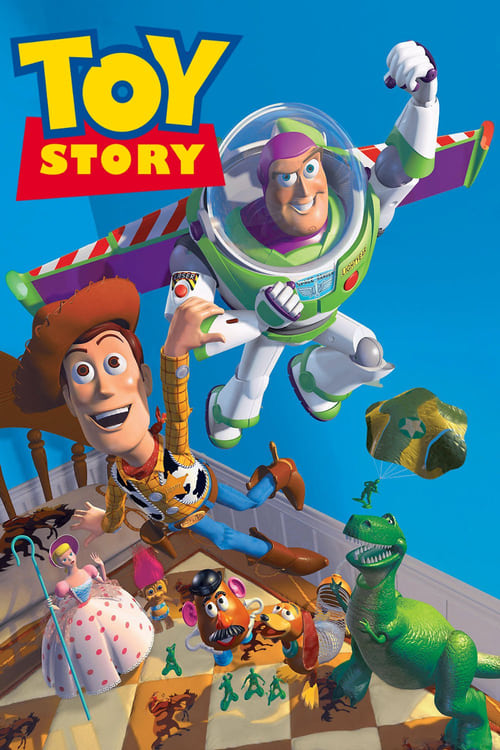

In [0]:
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = '53412b360933794d3b76c189e12097d0'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = 862
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

In [0]:
def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        tmbdid = links_df.filter(links_df["movieId"]==id).collect()[0]["tmdbId"]
        try:
            movie = tmdb.Movies(tmbdid).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"

Now we can get any movie poster with the MovieId

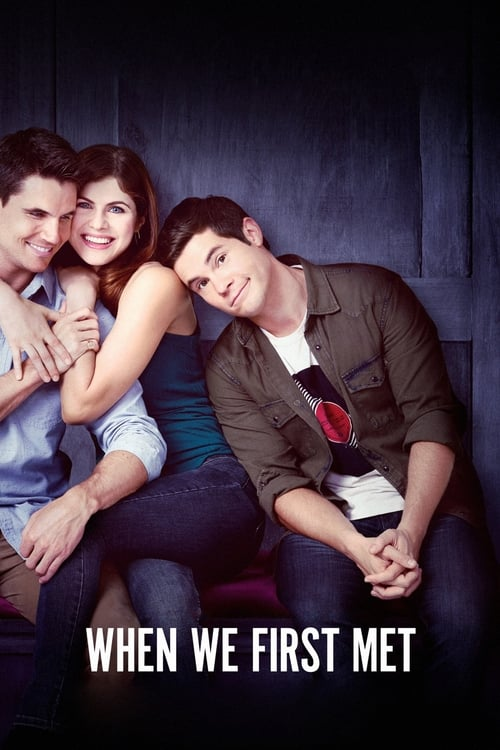

In [0]:
id = 184015
movie_poster_url = get_poster_url(id)
display(Image(movie_poster_url, width=200))

# Report 

## motivation
Dig deep into ALS  collaberative recommender engine and make recommendation with user based movie recommendation as well as find similar movies.
**motivation:** As artificial intelligence pervails in internet industry, more and more ecommerce platforms start to characterize their recommendation systems in order to provide better service. Collaborative filtering is one of the most popular recommendation algorithm which can be implemented with Alternating Least Squares (ALS) model in Spark ML. It would be a interesting and significant attempt to create a movie recommender for movie rating sites us

**step1. Data ETL and Data Exploration**
Explore the 4 datasets with movie_df(movie information), rating_information, links data frame and tags data frame. The minimum number of ratings per user is 20, and the minimum number of ratings per movie is 1. Among all 9742 movies and 610 users, there are more than 3000 movies are rated by only one users.

**step2. Online Analytical Processing**
Use spark sql to do OLAP and gain more knowledge on the movie genre. By exploring the genre of each movies, i found that there are 34 movies without genre label, and about half of movies are labeled as drama, and the least labeled genre is Film-Noir, only 87 movies.

**step3. Model Selection and Model Evaluation**
And then used ALS based approach to make our movie recommendation engine. Used grid search to output the best one with least rmse and used 3 fold cross validation to validate our final result, with training rmse = 0.64 and test rmse = 0.87 and overall rmse with 0.69.

**step4. Model Application: Recommend moive to users and Find the similar moives**
Made top 10 recommendations for user 575 and 273, and also output the top 5 similar movies for movie id 471; however as there is no id associate with movie id 463, therefore I didnot make recommendation for movie id 463. 
For user 575, the top recommendations are On the Beach, The Big Bus, Seve, Victory, Bill Hicks, Dylan Moran, Jetee etc..
For user 273, the top recommendations are On the Beach, Dylan Moran, Bill Hacks, Deathgasm, Victory, Seve, The Big Bus etc..
For movieid 471 the similar movies are What’s Eating Gilbert Grape, Term of Endearment, Angela’s Ashes, Cutting Edge, Memphis Belle etc.

**Output and Conclusion**
In this project, I built a ALS model with Spark APIs based on MovieLens dataset, predicted the ratings for the movies and made specific recommendation to users accordingly. The RMSE of the best model is approximately 0.87